In [1]:
"""
numpy-1.26.4
scikit-learn-1.5.2
tensorflow-2.18.0
timm-1.0.11
huggingface_hub-0.26.2

@misc{szegedy2016inceptionv4,
      title={Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning}, 
      author={Christian Szegedy and Sergey Ioffe and Vincent Vanhoucke and Alex Alemi},
      year={2016},
      eprint={1602.07261},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

"""
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.datasets import fetch_lfw_people
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchmetrics.classification import Accuracy
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

torch.cuda.empty_cache()

GPU is available: NVIDIA GeForce RTX 4090


Inplementation of InceptionV3 code of LFW when N>= 30

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)  # Load full size image
X = lfw_people.images
y = lfw_people.target
k = len(np.unique(y))
target_names = lfw_people.target_names

# Resize images to 299x299 for InceptionV4
def preprocess_images(X):
    X_resized = []
    for img in X:
        # Convert to 3 channels (RGB) and resize to 299x299
        img_rgb = np.stack([img]*3, axis=-1)  # Convert grayscale to RGB
        img_resized = array_to_img(img_rgb).resize((299, 299))
        img_resized = img_to_array(img_resized)
        X_resized.append(img_resized)
    X_resized = np.array(X_resized)
    return preprocess_input(X_resized)  # Preprocess for InceptionV4

X_resized = preprocess_images(X)
print("Shape of resized data:", X_resized.shape)  # Should be (n_samples, 299, 299, 3)

Shape of resized data: (2370, 299, 299, 3)


In [4]:
# Convert X_resized and y into PyTorch tensors and move to GPU
X_tensor = torch.tensor(X_resized, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)  # Labels should be long type for classification

# CHANGE: Change shape from (n_samples, 299, 299, 3) to (n_samples, 3, 299, 299) due to PyTorch models
X_tensor = X_tensor.permute(0, 3, 1, 2)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Move to GPU
X_train, X_val = X_train.to(device), X_val.to(device)
y_train, y_val = y_train.to(device), y_val.to(device)

# Create DataLoader for batching during training
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
# Define the full model, adding a custom classification layer

class InceptionV3_Transfer(nn.Module):
    def __init__(self, base_model, num_classes):
        super(InceptionV3_Transfer, self).__init__()
        self.base_model = base_model
        self.fc = nn.Linear(base_model.num_features, num_classes)  # Fully connected layer for classification
    
    def forward(self, x):
        x = self.base_model(x)  # Extract features
        x = self.fc(x)  # Pass through the custom classification layer
        return x

# Create the model
base_model = timm.create_model('inception_v3', pretrained=True, num_classes=0)  # Remove classification head
model = InceptionV3_Transfer(base_model, k)

# Move to GPU
model = model.to(device)

# Loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam with learning rate of 1e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Accuracy metric and move to GPU
accuracy_metric = Accuracy(task="multiclass", num_classes=k).to(device)



Epoch [1/10], Loss: 2.5872, Accuracy: 34.92%
Epoch [2/10], Loss: 1.2585, Accuracy: 68.67%
Epoch [3/10], Loss: 0.4200, Accuracy: 92.99%
Epoch [4/10], Loss: 0.1070, Accuracy: 99.16%
Epoch [5/10], Loss: 0.0386, Accuracy: 99.95%
Epoch [6/10], Loss: 0.0299, Accuracy: 99.89%
Epoch [7/10], Loss: 0.0211, Accuracy: 99.89%
Epoch [8/10], Loss: 0.0328, Accuracy: 99.58%
Epoch [9/10], Loss: 0.0533, Accuracy: 99.31%
Epoch [10/10], Loss: 0.0487, Accuracy: 99.16%


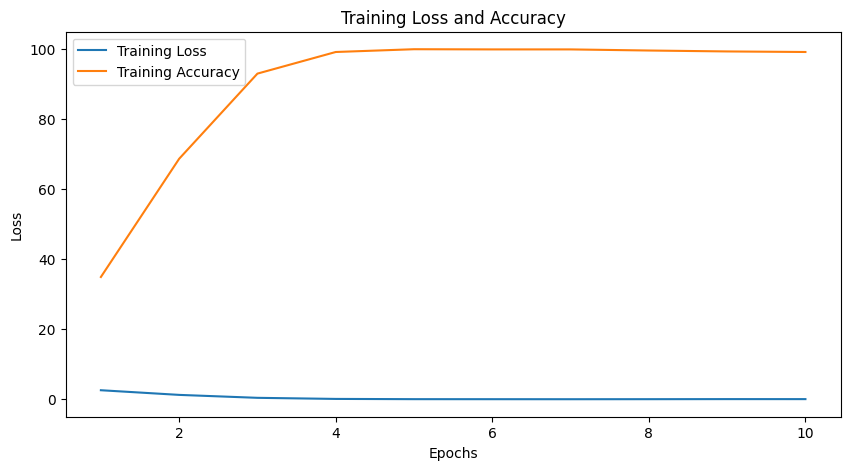

In [6]:
# Training loop
epochs = 10
train_losses = []
train_accuracies = []
start_time = time.time()

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase
    for inputs, labels in train_loader:
        # Move to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        train_loss += loss.item()  # Accumulate loss
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Calculate training accuracy
    train_accuracy = correct / total * 100
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

seconds = time.time() - start_time

# plot training accuracy and loss for each epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()


In [7]:
print('Time Taken for each epoch:', time.strftime("%H:%M:%S",time.gmtime(seconds/10)))

Time Taken for each epoch: 00:00:03


In [8]:
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
correct = 0
total = 0

all_labels = []
all_preds = []

with torch.no_grad():  # No need to track gradients during validation
    for inputs, labels in val_loader:
        # Move to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Save true and predicted labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())  # Convert tensors to NumPy arrays
        all_preds.extend(predicted.cpu().numpy())

# Calculate validation accuracy
val_accuracy = correct / total * 100
print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Validation Loss: 0.3250, Validation Accuracy: 91.77%


Confusion Matrix:
[[ 4  0  0 ...  0  0  0]
 [ 0  6  0 ...  0  0  0]
 [ 0  0  7 ...  0  0  0]
 ...
 [ 0  0  0 ... 33  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  7]]

Top 5 most accurate classes:
Class Guillermo Coria: Accuracy 1.00, Data size 6
Class Kofi Annan: Accuracy 1.00, Data size 7
Class Hans Blix: Accuracy 1.00, Data size 6
Class Tom Ridge: Accuracy 1.00, Data size 5
Class Andre Agassi: Accuracy 1.00, Data size 7

Top 5 least accurate classes:
Class John Negroponte: Accuracy 0.25, Data size 4
Class David Beckham: Accuracy 0.60, Data size 5
Class Recep Tayyip Erdogan: Accuracy 0.62, Data size 8
Class Arnold Schwarzenegger: Accuracy 0.67, Data size 9
Class John Ashcroft: Accuracy 0.67, Data size 12


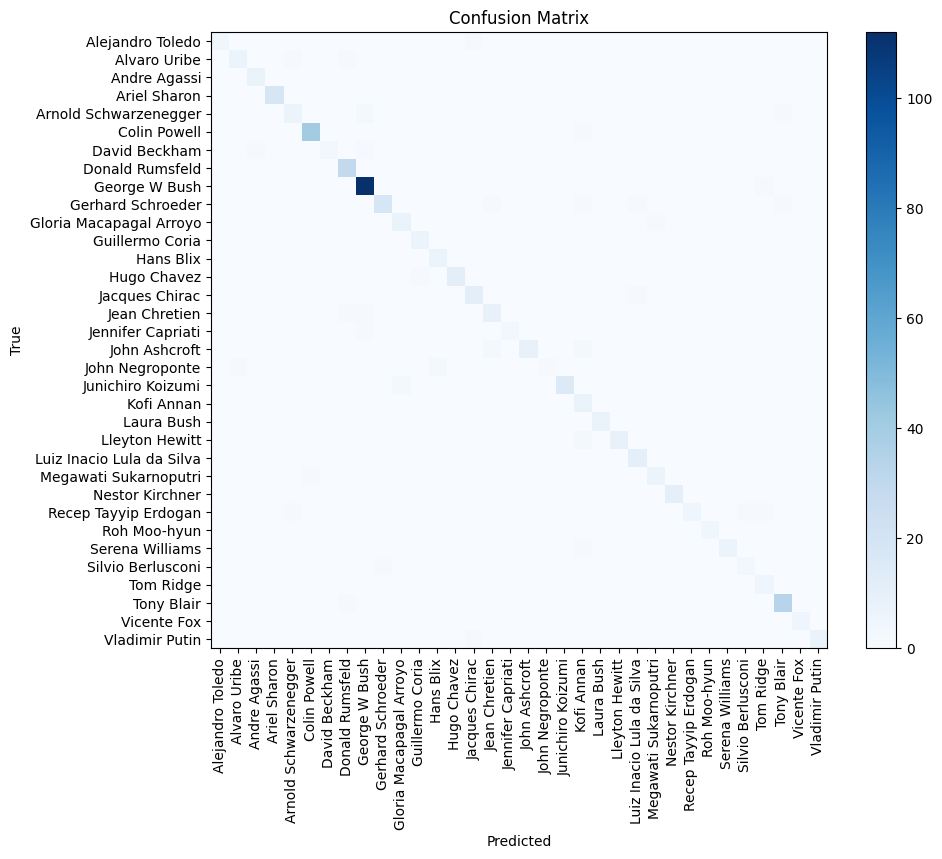

In [9]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy per class
class_correct = conf_matrix.diagonal()
class_totals = conf_matrix.sum(axis=1)
class_accuracy = class_correct / class_totals

# Top 5 most accurate classes
most_accurate_classes = np.argsort(class_accuracy)[-5:][::-1]
print("\nTop 5 most accurate classes:")
for cls in most_accurate_classes:
    print(f"Class {target_names[cls]}: Accuracy {class_accuracy[cls]:.2f}, Data size {class_totals[cls]}")

# Top 5 least accurate classes
least_accurate_classes = np.argsort(class_accuracy)[:5]
print("\nTop 5 least accurate classes:")
for cls in least_accurate_classes:
    print(f"Class {target_names[cls]}: Accuracy {class_accuracy[cls]:.2f}, Data size {class_totals[cls]}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(k), labels=target_names, rotation=90)
plt.yticks(ticks=np.arange(k), labels=target_names)
plt.show()